# Burster Izhikevich - Segregated Pipeline

In [1]:
from act.SyntheticGenerator import SyntheticGenerator
from act.act_types import SimParams, OptimizationParameters
from act.cell_model import TargetCell, ModuleParameters

random_seed = 42
num_slices_new = 10
num_slices_old = 5
experiment_folder = f"output/bursterIzh_seg_test_sl-{num_slices_new}-{num_slices_old}/{random_seed}"
#experiment_folder = f"output/bursterIzh_seg_surfaceTest_sl-{num_slices_new}/{random_seed}"
target_folder = experiment_folder + "/target"

# module 1 is for spiking, module 2 for bursting, final for refining all channels
module_1_folder = experiment_folder + "/module_1"
module_2_folder = experiment_folder + "/module_2"
module_final_folder = experiment_folder + "/module_final"

# pickled models
pickle_module_1 = f"output/bursterIzh_seg_new_sl-{num_slices_new}-{num_slices_old}/{random_seed}/module_1/trained_rf.pkl"
pickle_module_2 = f"output/bursterIzh_seg_new_sl-{num_slices_new}-{num_slices_old}/{random_seed}/module_2/trained_rf.pkl"
pickle_module_final = f"output/bursterIzh_seg_new_sl-{num_slices_new}-{num_slices_old}/{random_seed}/module_final/trained_rf.pkl"

target_cell = TargetCell(
    hoc_file="/home/mwsrgf/proj/ACT/data/Burster_Izhikevich_test/seg/template.hoc",
    mod_folder="/home/mwsrgf/proj/ACT/data/Burster_Izhikevich_test/seg",
    cell_name="Burster_Izh",
    g_names = ["gbar_na3", "gkdrbar_kdr","gbar_nap","gmbar_im", "glbar_leak"]
)

sim_par= SimParams(
            h_v_init=-67.0,  # Consistent with nrngui settings
            h_tstop=500,     # Simulation time in ms
            h_dt=0.1,      # Time step in ms
            h_celsius=6.3,   # Temperature in degrees Celsius
            CI_type="constant",
            CI_amps=[0.1,0.3,0.5],   # Current injection amplitude
            CI_dur=300,      # Duration of current injection
            CI_delay=100,     # Delay before current injection
            set_g_to=[]
        )

/home/mwsrgf/act-venv/lib64/python3.9/site-packages/torch/__init__.py:955: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)
--No graphics will be displayed.


# Generate Synthetic Data

In [2]:
sg = SyntheticGenerator(
    ModuleParameters(
        module_folder_name=target_folder,
        cell= target_cell,
        sim_params= sim_par,
        optim_params = OptimizationParameters(
            blocked_channels= []
        )
    )
)

sg.generate_synthetic_target_data("target_data.csv")

Blocking: []
Total number of jobs: 3
Total number of proccessors: 192
MECHANISMS already loaded.
/home/mwsrgf/proj/ACT/output/bursterIzh_seg_test_sl-10-5/42/target/synthetic_0.1_0.3_0.5_


In [3]:
passive_sim_par = SimParams(
            h_v_init = -67,
            h_tstop = 1500,
            h_dt = 0.001,
            h_celsius = 6.3,
            CI_type = "constant",
            CI_amps = [-1],    ##################### NEGATIVE CURRENT INJECTION ###################
            CI_dur = 1000,
            CI_delay = 500,
            set_g_to=[]
        )

sg_passive = SyntheticGenerator(
    ModuleParameters(
        module_folder_name=target_folder,
        cell= target_cell,
        sim_params= passive_sim_par,
        optim_params = OptimizationParameters(
            blocked_channels= []
        )
    )
)

sg_passive.generate_synthetic_target_data("passive_data.csv")

Blocking: []
Total number of jobs: 1
Total number of proccessors: 192
MECHANISMS already loaded.
/home/mwsrgf/proj/ACT/output/bursterIzh_seg_test_sl-10-5/42/target/synthetic_-1_


# Get Passive Properties

In [4]:
from act.PassivePropertiesModule import PassivePropertiesModule
from act.act_types import SimParams
from act.cell_model import TrainCell

train_cell = TrainCell(
    hoc_file="/home/mwsrgf/proj/ACT/data/Burster_Izhikevich_test/seg/template.hoc",
    mod_folder="/home/mwsrgf/proj/ACT/data/Burster_Izhikevich_test/seg",
    cell_name="Burster_Izh",
    g_names = ["gbar_na3", "gkdrbar_kdr","gbar_nap","gmbar_im", "glbar_leak"]
)

passive_mod = PassivePropertiesModule(
    train_cell=train_cell,
    sim_params=passive_sim_par,
    trace_filepath=f"{target_folder}/passive_data.csv",
    leak_conductance_variable="glbar_leak",
    leak_reversal_variable="el_leak"
)

In [5]:
passive_mod.set_passive_properties()
print(train_cell.passive_properties)

MECHANISMS already loaded.
Found 1 section(s) in this cell. Calculating the total surface area of the cell.
PassiveProperties(V_rest=-70.04364978423007, R_in=245.10914435358546, tau=55.539, Cm=2.4997001130263996, g_bar_leak=4.500801442277317e-05, cell_area=9.064641486925113e-05, leak_conductance_variable='glbar_leak', leak_reversal_variable='el_leak')


## Run Module 1 (Spiking)

In [6]:
from act.ACTModule import ACTModule
from act.act_types import OptimizationParameters, OptimizationParam
from act.cell_model import ModuleParameters

# gmbar_im = 0.0038, gkdrbar_kdr= 0.03, gbar_nap= 0.0004, gbar_na3= 0.05, glbar_leak= 3.6e-5
mod1 = ACTModule(
    ModuleParameters(
        module_folder_name=module_1_folder,
        cell= train_cell,
        target_traces_file = f"{target_folder}/target_data.csv",
        sim_params= sim_par,
        optim_params= OptimizationParameters(
            g_ranges_slices= [
                OptimizationParam(param="gbar_na3"),
                OptimizationParam(param="gkdrbar_kdr"),
                OptimizationParam(param="gbar_nap"),
                OptimizationParam(param="gmbar_im"),
                OptimizationParam(param="glbar_leak")
            ],
            train_features=["i_trace_stats", "number_of_spikes", "spike_times", "spike_height_stats", "trough_times", "trough_height_stats"],
            prediction_eval_method='fi_curve',
            rf_model=pickle_module_1,
            random_state=random_seed,
            save_file=f"{module_1_folder}/results/saved_metrics.json"
        )
    )
)

In [7]:
predicted_g_data_file = mod1.run()

RUNNING THE MODULE
LOADING TARGET TRACES
Model loaded successfully.
Predicted Conductances for each current injection intensity: 
[[6.08944444e-02 3.79066667e-02 4.00000000e-04 3.80000000e-03
  3.60085533e-05]
 [5.54611111e-02 2.78033333e-02 4.00000000e-04 3.80000000e-03
  3.60085533e-05]
 [6.04666667e-02 3.56033333e-02 4.00000000e-04 3.80000000e-03
  3.60085533e-05]]
SIMULATING PREDICTIONS
Total number of jobs: 9
Total number of proccessors: 192
MECHANISMS already loaded.
/home/mwsrgf/proj/ACT/output/bursterIzh_seg_test_sl-10-5/42/module_1/prediction_eval0
/home/mwsrgf/proj/ACT/output/bursterIzh_seg_test_sl-10-5/42/module_1/prediction_eval1
/home/mwsrgf/proj/ACT/output/bursterIzh_seg_test_sl-10-5/42/module_1/prediction_eval2
SELECTING BEST PREDICTION
FI curve MAE for each prediction: 
[2.2222222222222228, 2.2222222222222228, 2.2222222222222228]
{'gbar_na3': 0.0608944444444441, 'gkdrbar_kdr': 0.037906666666666776, 'gbar_nap': 0.00040000000000000734, 'gmbar_im': 0.003800000000000024, 'g

In [8]:
mod1.pickle_rf(mod1.rf_model,f"{module_1_folder}/trained_rf.pkl")
print(train_cell.predicted_g)

{'gbar_na3': 0.0608944444444441, 'gkdrbar_kdr': 0.037906666666666776, 'gbar_nap': 0.00040000000000000734, 'gmbar_im': 0.003800000000000024, 'glbar_leak': 3.600855333548278e-05}


## Run Module 2 (Bursting)

In [9]:
from act.ACTModule import ACTModule
from act.act_types import OptimizationParameters, OptimizationParam
from act.cell_model import ModuleParameters

# Allow all channels to vary by 20% their predicted value in the previous module
bounds_variation = 0.15

# gmbar_im = 0.0038, gkdrbar_kdr= 0.03, gbar_nap= 0.0004, gbar_na3= 0.05, glbar_leak= 3.6e-5
mod2 = ACTModule(
    ModuleParameters(
        module_folder_name=module_2_folder,
        cell= train_cell,
        target_traces_file = f"{target_folder}/target_data.csv",
        sim_params= sim_par,
        optim_params= OptimizationParameters(
            g_ranges_slices= [
                OptimizationParam(param="gbar_na3"),
                OptimizationParam(param="gkdrbar_kdr"),
                OptimizationParam(param="gbar_nap"),
                OptimizationParam(param="gmbar_im"),
                OptimizationParam(param="glbar_leak")
            ],
            train_features=["i_trace_stats", "number_of_spikes", "spike_times", "spike_height_stats", "trough_times", "trough_height_stats"],
            prediction_eval_method='fi_curve',
            rf_model=pickle_module_2,
            random_state=random_seed,
            save_file=f"{module_2_folder}/results/saved_metrics.json"
        )
    )
)

In [10]:
predicted_g_data_file = mod2.run()

RUNNING THE MODULE
LOADING TARGET TRACES
Model loaded successfully.
Predicted Conductances for each current injection intensity: 
[[5.93489583e-02 3.50235000e-02 4.05511111e-04 3.89120000e-03
  3.60085533e-05]
 [5.95442708e-02 3.55806180e-02 4.27333333e-04 3.91906667e-03
  3.60085533e-05]
 [5.97747396e-02 3.67192890e-02 4.29955556e-04 4.27542222e-03
  3.60085533e-05]]
SIMULATING PREDICTIONS
Total number of jobs: 9
Total number of proccessors: 192
MECHANISMS already loaded.
/home/mwsrgf/proj/ACT/output/bursterIzh_seg_test_sl-10-5/42/module_2/prediction_eval0
/home/mwsrgf/proj/ACT/output/bursterIzh_seg_test_sl-10-5/42/module_2/prediction_eval1
/home/mwsrgf/proj/ACT/output/bursterIzh_seg_test_sl-10-5/42/module_2/prediction_eval2
SELECTING BEST PREDICTION
FI curve MAE for each prediction: 
[2.2222222222222228, 2.2222222222222228, 2.2222222222222228]
{'gbar_na3': 0.0593489583333339, 'gkdrbar_kdr': 0.03502350000000006, 'gbar_nap': 0.00040551111111111033, 'gmbar_im': 0.0038912000000000157, 'g

In [11]:
mod2.pickle_rf(mod2.rf_model,f"{module_2_folder}/trained_rf.pkl")
print(train_cell.predicted_g)

{'gbar_na3': 0.0593489583333339, 'gkdrbar_kdr': 0.03502350000000006, 'gbar_nap': 0.00040551111111111033, 'gmbar_im': 0.0038912000000000157, 'glbar_leak': 3.600855333548278e-05}


## Run Fine Tuning Module

In [12]:
from act.ACTModule import ACTModule
from act.act_types import OptimizationParameters, OptimizationParam
from act.cell_model import ModuleParameters

bounds_variation = 0.15

final_mod = ACTModule(
    ModuleParameters(
        module_folder_name=module_final_folder,
        cell= train_cell,
        target_traces_file = f"{target_folder}/target_data.csv",
        sim_params= sim_par,
        optim_params= OptimizationParameters(
            g_ranges_slices= [
                OptimizationParam(param="gbar_na3"),
                OptimizationParam(param="gkdrbar_kdr"),
                OptimizationParam(param="gbar_nap"),
                OptimizationParam(param="gmbar_im"),
                OptimizationParam(param="glbar_leak")
            ],
            train_features=["i_trace_stats", "number_of_spikes", "spike_times", "spike_height_stats", "trough_times", "trough_height_stats"],
            prediction_eval_method='fi_curve',
            rf_model=pickle_module_final,
            random_state=random_seed,
            save_file=f"{module_final_folder}/results/saved_metrics.json"
        )
    )
)

In [13]:
final_predicted_g_data_file = final_mod.run()

RUNNING THE MODULE
LOADING TARGET TRACES
Model loaded successfully.
Predicted Conductances for each current injection intensity: 
[[5.86044196e-02 3.49417148e-02 4.17320311e-04 3.93350368e-03
  3.60085533e-05]
 [5.85967670e-02 3.50559564e-02 4.37346551e-04 3.84844920e-03
  3.60085533e-05]
 [5.86618136e-02 3.54788933e-02 3.92576351e-04 4.07458381e-03
  3.60085533e-05]]
SIMULATING PREDICTIONS
Total number of jobs: 9
Total number of proccessors: 192
MECHANISMS already loaded.
/home/mwsrgf/proj/ACT/output/bursterIzh_seg_test_sl-10-5/42/module_final/prediction_eval0
/home/mwsrgf/proj/ACT/output/bursterIzh_seg_test_sl-10-5/42/module_final/prediction_eval1
/home/mwsrgf/proj/ACT/output/bursterIzh_seg_test_sl-10-5/42/module_final/prediction_eval2
SELECTING BEST PREDICTION
FI curve MAE for each prediction: 
[2.2222222222222228, 3.333333333333334, 1.1111111111111114]
{'gbar_na3': 0.058661813606772334, 'gkdrbar_kdr': 0.03547889326237532, 'gbar_nap': 0.00039257635111110347, 'gmbar_im': 0.0040745838

In [14]:
final_mod.pickle_rf(final_mod.rf_model,f"{module_final_folder}/trained_rf.pkl")
print(train_cell.predicted_g)

{'gbar_na3': 0.058661813606772334, 'gkdrbar_kdr': 0.03547889326237532, 'gbar_nap': 0.00039257635111110347, 'gmbar_im': 0.004074583809444497, 'glbar_leak': 3.600855333548278e-05}


# Results & Metrics

In [15]:
from act import ACTPlot
ACTPlot.plot_v_comparison(
    final_predicted_g_data_file, 
    module_final_folder, 
    sim_par["CI_amps"],
    sim_par["h_dt"]
    )

ACTPlot.plot_fi_comparison(
    module_final_folder, 
    sim_par["CI_amps"]
    )

In [16]:
from act.Metrics import Metrics

metrics = Metrics()

mean, stdev = metrics.print_interspike_interval_comparison(
    module_final_folder,
    final_predicted_g_data_file,
    sim_par["CI_amps"], 
    sim_par["h_dt"],
    first_n_spikes=5,
    save_file=f"{module_final_folder}/results/saved_metrics.json"
)

metrics.print_prediction_g_mae(
    actual_g={"gbar_na3": 0.05, "gkdrbar_kdr": 0.03,"gbar_nap": 0.0004,"gmbar_im": 0.0038, "glbar_leak": 3.6e-5},
    save_file=f"{module_final_folder}/results/saved_metrics.json"
)

Interspike times (Target): [[2.410e+01 2.171e+02 1.000e+06 1.000e+06]
 [1.900e+01 2.320e+01 2.328e+02 1.000e+06]
 [1.660e+01 1.810e+01 1.000e+06 1.000e+06]]
Interspike times (Prediction): [[3.000e+01 2.112e+02 1.000e+06 1.000e+06]
 [2.060e+01 2.660e+01 1.000e+06 1.000e+06]
 [1.750e+01 1.910e+01 1.000e+06 1.000e+06]]
MAE for each I injection: [2.950000000000003, 249943.05, 0.475000000000005]
Mean interspike-interval MAE: 83315.49166666667
Standard Deviation interspike-interval MAE: 117823.47643438951
MAE of final g prediction: 0.002884544576163306


Smallest MAE values (gbar_na3, gmbar_im, MAE): 
[[0.05086863 0.0039204  0.30042288]
 [0.05086863 0.00367148 0.31626269]
 [0.05086863 0.00404485 0.36386619]
 [0.04920081 0.00354703 0.37632402]
 [0.05086863 0.00354703 0.41885787]
 [0.04920081 0.00367148 0.42118451]]


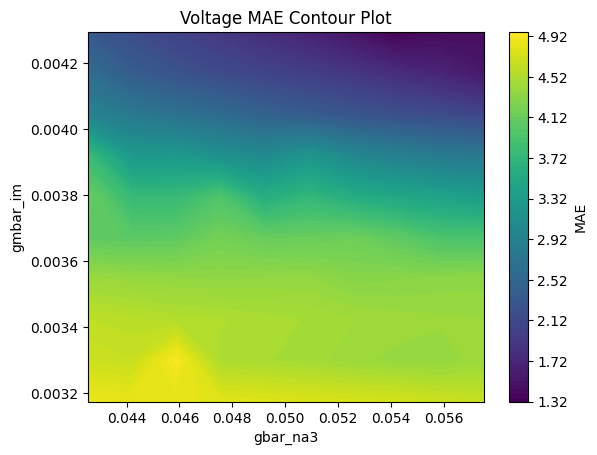

In [17]:
from act import ACTPlot as actplt
from act.act_types import SimParams


random_seed = 42
num_slices_new = 10
experiment_folder = f"output/bursterIzh_seg_surfaceTest_sl-{num_slices_new}/{random_seed}"
target_folder = experiment_folder + "/target"
module_final_folder = experiment_folder + "/module_final"

sim_par= SimParams(
            h_v_init=-67.0,  # Consistent with nrngui settings
            h_tstop=500,     # Simulation time in ms
            h_dt=0.1,      # Time step in ms
            h_celsius=6.3,   # Temperature in degrees Celsius
            CI_type="constant",
            CI_amps=[0.1,0.3,0.5],   # Current injection amplitude
            CI_dur=300,      # Duration of current injection
            CI_delay=100,     # Delay before current injection
            set_g_to=[]
        )

#["gbar_na3", "gkdrbar_kdr","gbar_nap","gmbar_im", "glbar_leak"]

actplt.plot_training_v_mae_contour_plot(
module_final_folder,
sim_par["CI_amps"],
sim_par["CI_delay"],
sim_par["h_dt"],
index1=0,
index2=3,
g_names=["gbar_na3", "gkdrbar_kdr","gbar_nap","gmbar_im"],
num_levels=100,
results_filename=f"{module_final_folder}/results/V_Trace_Contour_Plot_na3_im.png"
)